# 학습용 데이터셋 만들기

In [1]:
import glob
import torchvision.transforms as tf

from torch.utils.data.dataset import Dataset
from PIL import Image

class Celeba(Dataset):
    def __init__(self):
        self.imgs = glob.glob("/home/restful3/datasets_local/GAN/img_align_celeba/*.jpg")
        
        mean_std = (0.5, 0.5, 0.5)
        
        self.low_res_tf = tf.Compose([
            tf.Resize((32, 32)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])
        
        self.high_res_tf = tf.Compose([
            tf.Resize((64, 64)),
            tf.ToTensor(),
            tf.Normalize(mean_std, mean_std)
        ])
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = Image.open(self.imgs[i])
        
        img_low_res = self.low_res_tf(img)
        img_high_res = self.high_res_tf(img)        
        
        return [img_low_res, img_high_res]

# SRGAN 생성자 정의하기

In [2]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        
    def forward(self, x):
        x_ = x
        x = self.layers(x)
        
        x += x_
        
        return x

In [3]:
class UpSample(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__(
            nn.Conv2d(in_channels, out_channels,
                     kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )        

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        
        self.res_blocks = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64)            
        )
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.upsample_blocks = UpSample(in_channels=64, out_channels=256)
        
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x_ = x
        
        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        x += x_
        
        x = self.upsample_blocks(x)
        x = self.conv3(x)
        
        return x

# SRGAN 감별자 정의하기

In [5]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DiscBlock, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                     kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        return self.layers(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 
                     kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )
        
        self.blocks = DiscBlock(in_channels=64, out_channels=64)
        
        self.fc1 = nn.Linear(65536, 1024)
        self.activation = nn.LeakyReLU()
        self.fc2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.blocks(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# CNN 특징 추출기 정의하기

In [7]:
import torch
from torchvision.models.vgg import vgg19

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        
        self.feature_extractor = nn.Sequential(
            *list(vgg19_model.features.children())[:9]
        )
        
    def forward(self, img):
        return self.feature_extractor(img)

# 모델 학습하기

In [8]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [9]:
dataset = Celeba()
batch_size = 8
loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [10]:
G = Generator().to(device)
D = Discriminator().to(device)

In [11]:
feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval() # 학습을 하는 것이 아니라서 평가 모드 설정

/home/restful3/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/restful3/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
  )
)

In [12]:
G_optim = Adam(G.parameters(), lr = 0.0001, betas = (0.5, 0.999))
D_optim = Adam(D.parameters(), lr = 0.0001, betas = (0.5, 0.999))

In [13]:
for epoch in range(1):
    iterator = tqdm.tqdm(loader)
    
    for i, (low_res, high_res) in enumerate(iterator):
        G_optim.zero_grad()
        D_optim.zero_grad()
        
        label_true = torch.ones(batch_size, dtype=torch.float32).to(device)
        label_false = torch.zeros(batch_size, dtype=torch.float32).to(device)
        
        fake_hr = G(low_res.to(device))
        GAN_loss = nn.MSELoss()(D(fake_hr), label_true)
        
        fake_features = feature_extractor(fake_hr)
        real_features = feature_extractor(high_res.to(device))
        
        content_loss = nn.L1Loss()(fake_features, real_features)
        loss_G = content_loss + 0.0001*GAN_loss
        loss_G.backward()
        G_optim.step()
        
        real_loss = nn.MSELoss()(D(high_res.to(device)), label_true)
        fake_loss = nn.MSELoss()(D(fake_hr.detach()), label_false)
        D_loss = (real_loss + fake_loss)/2
        D_loss.backward()
        D_optim.step()
        
        iterator.set_description(f'epoch : {epoch}, G_loss : {GAN_loss}, D_loss : {D_loss}')
        
torch.save(G.state_dict(), './models/SRGAN_G.pth')        
torch.save(D.state_dict(), './models/SRGAN_D.pth')        

  0%|                                                 | 0/25325 [00:00<?, ?it/s]/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch : 0, G_loss : 1.0, D_loss : 0.0: 100%|▉| 25324/25325 [49:04<00:00,  8.55it/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch : 0, G_loss : 1.0, D_loss : 0.0: 100%|█| 25325/25325 [49:04<00:00,  8.60it


# 모델 성능 평가하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


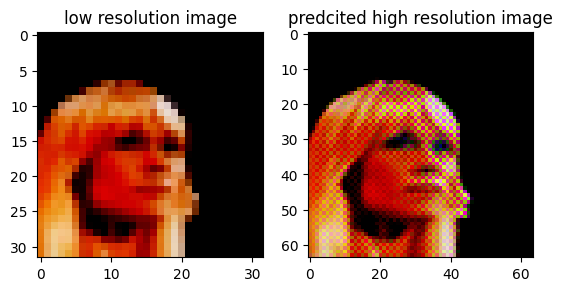

In [15]:
import matplotlib.pyplot as plt

G.load_state_dict(torch.load('./models/SRGAN_G.pth', map_location=device))

with torch.no_grad():
    low_res, high_res = dataset[1]
    
    input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
    
    pred = G(input_tensor)
    pred = pred.squeeze()
    pred = pred.permute(1, 2, 0).cpu().numpy()
    
    low_res = low_res.permute(1, 2, 0).numpy()
    
    plt.subplot(1, 2, 1)
    plt.title('low resolution image')
    plt.imshow(low_res)
    plt.subplot(1, 2, 2)
    plt.title('predcited high resolution image')
    plt.imshow(pred)    
    plt.show()
    